In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

import itertools
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time

np.set_printoptions(suppress=True)

/home/kevin/.pyenv/versions/3.7.3/envs/IM7001/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
yelpZip_preprocessed = pd.read_pickle('../../data/processed/yelpZip_preprocessed.pkl')

yelpZip_data = yelpZip_preprocessed.copy()
yelpZip_data.head()

,userId,prodId,date,content,content_len,label,rating,overall_review_similarity,review_count_today,rating_deviation,tokenize_content,tokenize_content_len,corpus
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",36,-1,1.0,0.0000,1,2.613636,"[drink, bad, hot, chocolate, watered, latte, b...",17,drink bad hot chocolate watered latte burnt ta...
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,248,-1,1.0,0.0000,1,2.613636,"[worst, experience, ive, ever, casual, coffeel...",122,worst experience ive ever casual coffeelight f...
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,50,-1,3.0,0.3298,1,0.613636,"[located, site, old, spruce, st, video, mild, ...",24,located site old spruce st video mild cofee go...
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,233,-1,5.0,0.0000,1,1.386364,"[enjoyed, coffee, breakfast, twice, toast, rec...",129,enjoyed coffee breakfast twice toast recent vi...
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,152,-1,5.0,0.0000,1,1.386364,"[love, toast, food, choice, fantastic, love, s...",79,love toast food choice fantastic love serve br...


# Experiment 1  - without removing top N common words

## Prepare dataset to feed into model

In [3]:
yelpZip_data['label'].replace(1, True, inplace=True)
yelpZip_data['label'].replace(-1, False, inplace=True)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(yelpZip_data.drop('label',axis=1), yelpZip_data['label'], test_size=0.25, random_state=42)

### 1. Transform corpus to vector

In [5]:
since = time.time()

vectorizer = CountVectorizer(max_features= 15000)
vectorizer.fit(x_train['corpus'])

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 21.006685256958008s


In [6]:
since = time.time()

x_train_review_vector = vectorizer.transform(x_train['corpus'])
x_test_review_vector  = vectorizer.transform(x_test['corpus'])

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 29.016160488128662s


### 2. Concat vectorized features with other features

In [7]:
features = ['overall_review_similarity', 'review_count_today', 'rating_deviation', 'tokenize_content_len']

x_train = sp.sparse.hstack((x_train_review_vector, x_train[features].values))
x_test = sp.sparse.hstack((x_test_review_vector, x_test[features].values))

## Train and Evaluate

### Experiment 1A. Without Oversampling

In [8]:
since = time.time()

classifier = LogisticRegression(max_iter=100, n_jobs=-1)
classifier.fit(x_train, y_train)
score = classifier.score(x_test, y_test)

print(f'Accuracy: {score}\n')
time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Accuracy: 0.8690765691751561

Complete in 0.0m 15.063467502593994s


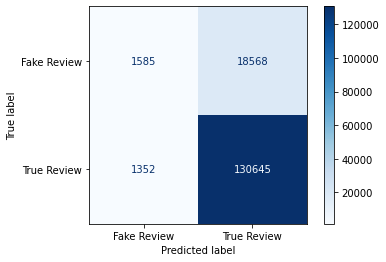

In [9]:
class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

In [10]:
predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.54      0.08      0.14     20153
        True       0.88      0.99      0.93    131997

    accuracy                           0.87    152150
   macro avg       0.71      0.53      0.53    152150
weighted avg       0.83      0.87      0.82    152150



### Experiment 1B. With Oversampling

In [11]:
since = time.time()

ros = SMOTE(random_state=42)
x_train_oversampled, y_train_oversampled = ros.fit_resample(x_train, y_train)

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 3.0m 47.25663924217224s


In [12]:
since = time.time()

classifier = LogisticRegression(max_iter=100, n_jobs=-1)
classifier.fit(x_train_oversampled, y_train_oversampled)
score = classifier.score(x_test, y_test)

print(f'Accuracy: {score}\n')
time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Accuracy: 0.7375681892868879

Complete in 0.0m 27.570631504058838s


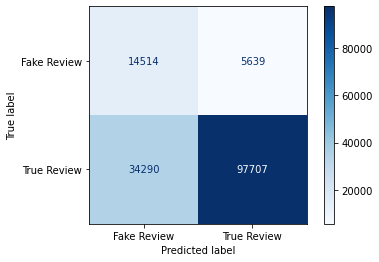

In [13]:
class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

In [14]:
predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.30      0.72      0.42     20153
        True       0.95      0.74      0.83    131997

    accuracy                           0.74    152150
   macro avg       0.62      0.73      0.63    152150
weighted avg       0.86      0.74      0.78    152150



# Experiment 2 - remove top N common words

## Prepare dataset to feed into model

In [15]:
x_train, x_test, y_train, y_test = train_test_split(yelpZip_data.drop('label',axis=1), yelpZip_data['label'], test_size=0.25, random_state=42)

### 1. Calculate top n common words in both Fake and True reviews

In [16]:
top_n = 20

true_word_list = list(yelpZip_data[yelpZip_data['label']==True]['tokenize_content'])
true_word_list = list(itertools.chain.from_iterable(true_word_list))
true_word_common = Counter(true_word_list).most_common(top_n)

fake_word_list = list(yelpZip_data[yelpZip_data['label']!=True]['tokenize_content'])
fake_word_list = list(itertools.chain.from_iterable(fake_word_list))
fake_word_common = Counter(fake_word_list).most_common(top_n)

df_true = pd.DataFrame(true_word_common)
df_false = pd.DataFrame(fake_word_common)
common_words = list(set(df_true.iloc[:,0]) & set(df_false.iloc[:,0]))
print(common_words)
print(f'there are {len(common_words)} common word in top {top_n} words')

['place', 'great', 'really', 'service', 'time', 'restaurant', 'would', 'delicious', 'like', 'back', 'go', 'best', 'get', 'one', 'food', 'good']
there are 16 common word in top 20 words


### 2. Transform corpus to vector

In [17]:
since = time.time()

vectorizer = CountVectorizer(max_features= 15000, stop_words=common_words)
vectorizer.fit(x_train['corpus'])

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 22.931886911392212s


In [18]:
since = time.time()

x_train_review_vector = vectorizer.transform(x_train['corpus'])
x_test_review_vector  = vectorizer.transform(x_test['corpus'])

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 0.0m 30.2525053024292s


### 3. Concat vectorized features with other features

In [19]:
features = ['overall_review_similarity', 'review_count_today', 'rating_deviation', 'tokenize_content_len']

x_train = sp.sparse.hstack((x_train_review_vector, x_train[features].values))
x_test = sp.sparse.hstack((x_test_review_vector, x_test[features].values))

## Train and Evaluate

### Experiment 2A. Without Oversampling

In [20]:
since = time.time()

classifier = LogisticRegression(max_iter=100, n_jobs=-1)
classifier.fit(x_train, y_train)
score = classifier.score(x_test, y_test)

print(f'Accuracy: {score}\n')
time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Accuracy: 0.8695234965494578

Complete in 0.0m 13.283277750015259s


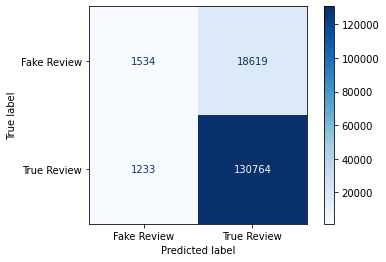

In [21]:
class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

In [22]:
predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.55      0.08      0.13     20153
        True       0.88      0.99      0.93    131997

    accuracy                           0.87    152150
   macro avg       0.71      0.53      0.53    152150
weighted avg       0.83      0.87      0.82    152150



### Experiment 2B. With Oversampling

In [23]:
since = time.time()

ros = SMOTE(random_state=42)
x_train_oversampled, y_train_oversampled = ros.fit_resample(x_train, y_train)

time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Complete in 3.0m 38.60737991333008s


In [24]:
since = time.time()

classifier = LogisticRegression(max_iter=100, n_jobs=-1)
classifier.fit(x_train_oversampled, y_train_oversampled)
score = classifier.score(x_test, y_test)

print(f'Accuracy: {score}\n')
time_elapsed = time.time() - since
print(f'Complete in {time_elapsed // 60}m {time_elapsed % 60}s')

Accuracy: 0.7355110088728228

Complete in 0.0m 22.786044359207153s


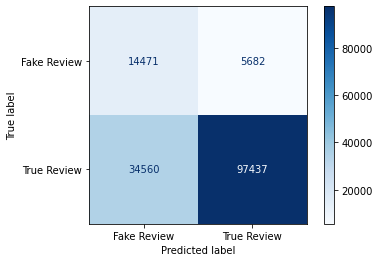

In [25]:
class_names = ['Fake Review', 'True Review']

disp = plot_confusion_matrix(classifier, x_test, y_test, display_labels=class_names, 
                             cmap=plt.cm.Blues, values_format='.6g')

plt.show()

In [26]:
predictions = classifier.predict(x_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       False       0.30      0.72      0.42     20153
        True       0.94      0.74      0.83    131997

    accuracy                           0.74    152150
   macro avg       0.62      0.73      0.62    152150
weighted avg       0.86      0.74      0.77    152150

